## Introduction

We have done a great job so far! This notebook is our last part of this project and also the most exciting section as we are going to have our own recommendation system built on the spotify database. This system allows us to enter the song's name and artist(s) to return a dataframe that consists of similar songs based on the song we inputted. My work is inspired by this extraordinary work on [Kaggle](https://www.kaggle.com/vatsalmavani/music-recommendation-system-using-spotify-dataset).

Let's get started!

In [1]:
import numpy as np
import pandas as pd
import random

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances, classification_report
from scipy.spatial.distance import cdist
from collections import defaultdict
import difflib
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in csv
data = pd.read_csv("data/songs.csv")
data = data.drop(columns='year')
print(data.shape)
data.head()

(6350, 16)


name        artists  popularity  danceability  energy  key  \
0             晴天       Jay Chou          61         0.547   0.567  7.0   
1              零       Alan Kuo          42         0.494   0.565  3.0   
2  寶貝 (In a Day)  Deserts Chang          44         0.827   0.160  0.0   
3             雨愛    Rainie Yang          55         0.422   0.657  4.0   
4             掉了    A-Mei Chang           0         0.547   0.475  1.0   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -7.295   1.0       0.0242         0.276          0.000548    0.1040   
1    -4.958   0.0       0.0291         0.061          0.000000    0.1210   
2   -12.729   1.0       0.0483         0.887          0.000000    0.1050   
3    -5.274   1.0       0.0292         0.214          0.000000    0.1290   
4    -6.613   1.0       0.0278         0.811          0.000000    0.0722   

   valence    tempo  duration_ms  language  
0   0.3990  137.130     269747.0  Mandarin  
1   0.0989  120.026     279893.0  Mandarin  
2   0.3880  119.891     145440.0  Mandarin  
3   0.2180  159.957     261560.0  Mandarin  
4   0.1420  161.965     239560.0  Mandarin

## Clustering Songs with K-Means

Before applying the KMeans algorithm to cluster the songs, let's start our first step by standardizing the data since not all the quantitative features are on the same scaled. Some code are taken from [here](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/).

In [3]:
# standardizing the data
X = data.select_dtypes(np.number)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

0             1             2             3             4   \
count  6.350000e+03  6.350000e+03  6.350000e+03  6.350000e+03  6.350000e+03   
mean  -1.410973e-15 -1.006876e-15  4.654195e-17 -2.242563e-16 -2.067834e-16   
std    1.000079e+00  1.000079e+00  1.000079e+00  1.000079e+00  1.000079e+00   
min   -1.399393e+00 -3.065731e+00 -2.782117e+00 -1.488540e+00 -6.121420e+00   
25%   -9.129582e-01 -7.022387e-01 -7.191197e-01 -9.224704e-01 -5.261727e-01   
50%    1.085555e-01  6.200420e-02 -9.642348e-02 -7.336617e-02  1.105317e-01   
75%    7.409210e-01  7.413313e-01  7.794013e-01  7.757380e-01  6.976857e-01   
max    3.416314e+00  2.588252e+00  2.171608e+00  1.624842e+00  2.309827e+00   

                 5             6             7             8             9   \
count  6.350000e+03  6.350000e+03  6.350000e+03  6.350000e+03  6.350000e+03   
mean   1.498668e-14 -4.853510e-17  1.963915e-16  3.673125e-15 -1.436821e-16   
std    1.000079e+00  1.000079e+00  1.000079e+00  1.000079e+00  1.000079e+00   
min   -1.408056e+00 -6.218847e-01 -1.565510e+00 -1.188799e-01 -1.257925e+00   
25%   -1.408056e+00 -4.931434e-01 -9.857620e-01 -1.188799e-01 -5.687471e-01   
50%    7.101992e-01 -3.875467e-01  9.029309e-02 -1.188799e-01 -3.889252e-01   
75%    7.101992e-01 -1.470347e-02  8.931179e-01 -1.187647e-01  1.965415e-01   
max    7.101992e-01  1.190941e+01  1.787020e+00  1.606338e+01  6.912681e+00   

                 10            11            12  
count  6.350000e+03  6.350000e+03  6.350000e+03  
mean   7.619452e-17  7.448110e-18 -5.077303e-17  
std    1.000079e+00  1.000079e+00  1.000079e+00  
min   -1.887855e+00 -2.573449e+00 -4.430433e+00  
25%   -8.051913e-01 -7.900965e-01 -6.681302e-01  
50%   -2.060338e-01  2.128289e-03 -1.109494e-01  
75%    7.368264e-01  6.102748e-01  5.935298e-01  
max    2.552877e+00  3.405486e+00  1.528239e+01

We've completely scaled the data. Now we can apply the KMeans algorithm and fit it to our scaled data.

In [4]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

# inertia on the fitted data
kmeans.inertia_

67320.25402289201

Our inertia is 67320, which is kind of high. Perhaps k = 2 is not a good number of clusters for our model. Let's use the Elbow method to find the best k.

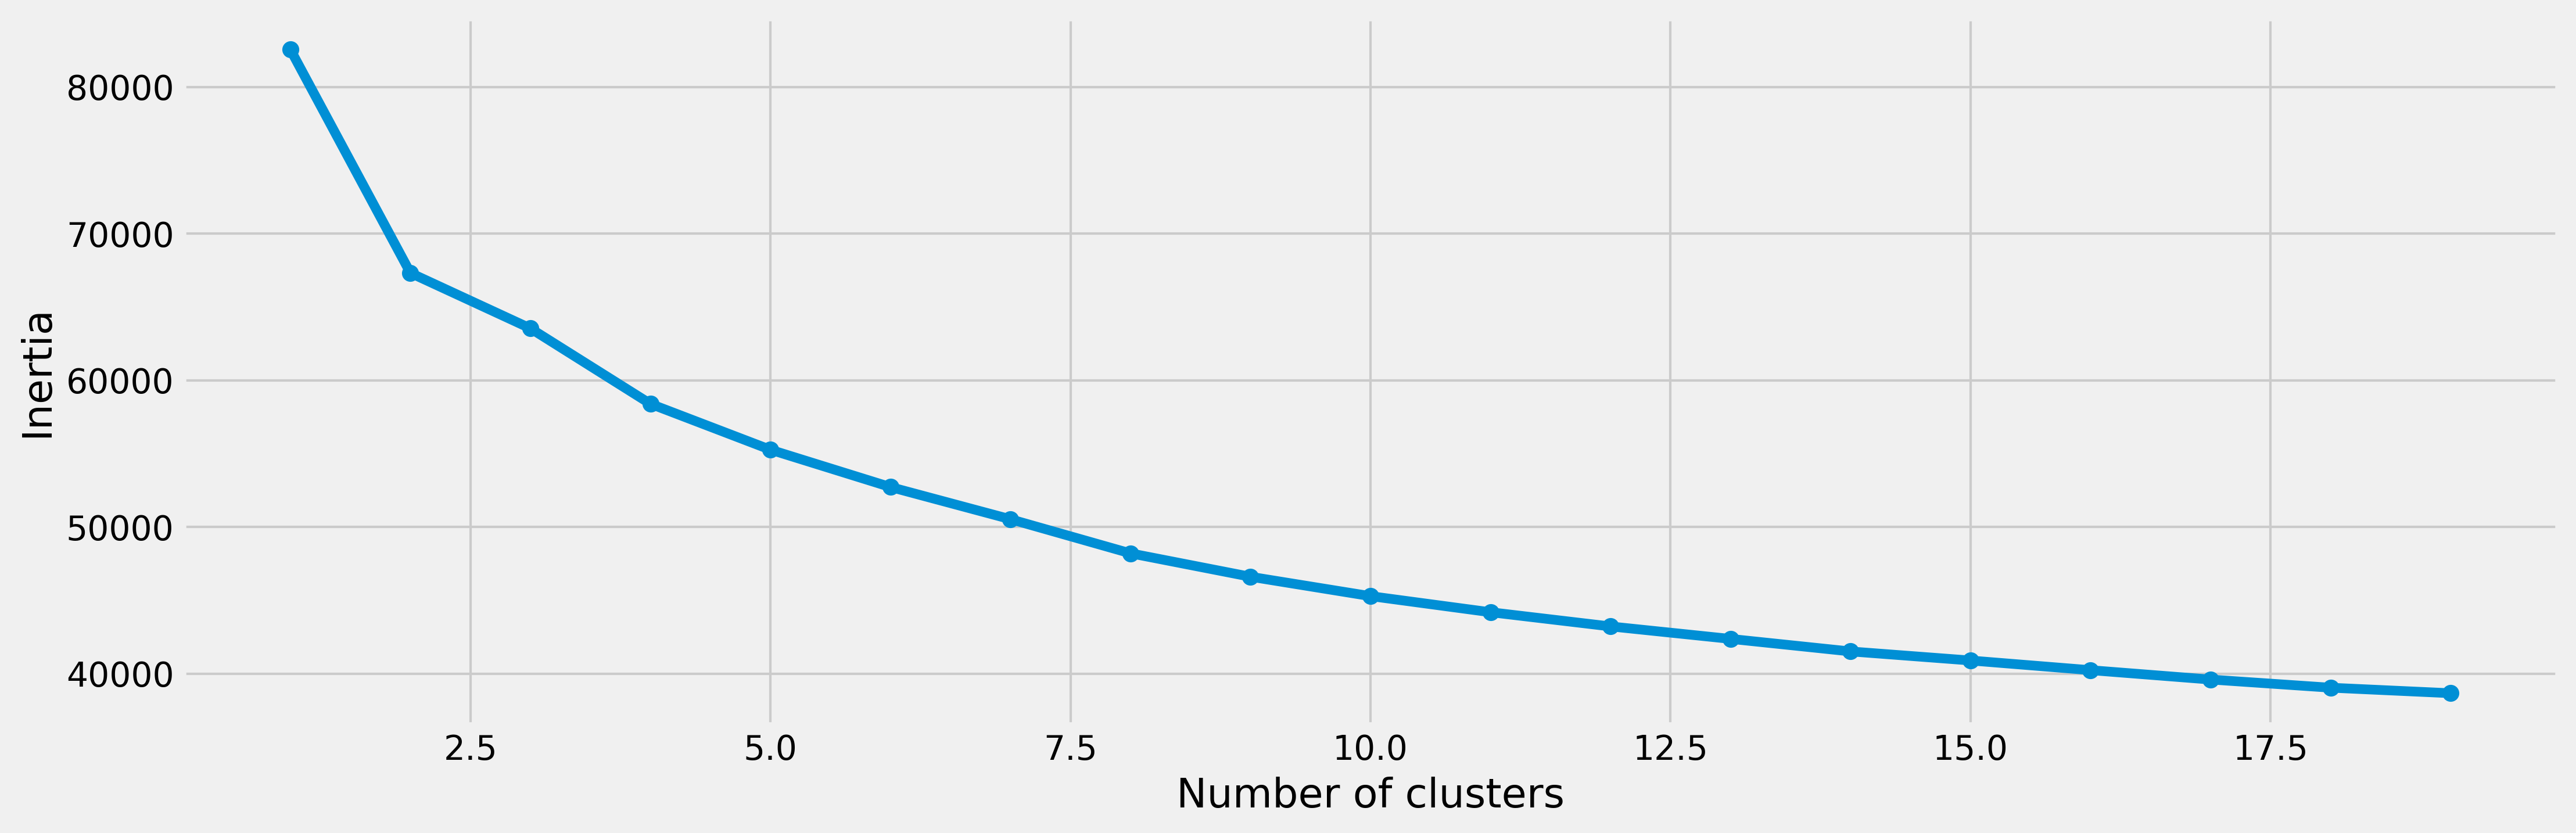

In [23]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.rcParams['figure.dpi'] = 300
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()

As shown above, the plot looks like an arm with a slight elbow at k = 3. Therefore, we will proceed with 3 for k.

In [6]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 3, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

# assign pred to a new column in data, cluster_label
data['cluster_label'] = pred

# make a df to show the count for each cluster
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

2    2663
1    2232
0    1455
Name: cluster, dtype: int64

There are 2663 songs in cluster 2, 2232 songs in cluster 1, and 1455 in cluster 0. Let's visualize it with PCA.

In [7]:
# visualize with PCA
pca = PCA(n_components=2)
song_embedding = pca.fit_transform(data_scaled)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

Ah hah! We can understand what we did so far better with the plot! It seems like they are not messed up with each other pretty much, despite some blue points in the pink cluster (cluster 1) and the yellow cluster (cluster 2). We can also see the blue cluster (cluster 0) and the yellow cluster (cluster 2) have some outliers.  

### Evaluate Other Clustering Algorithms

We'll be using the silhouette score to evaluate the performance of each algorithm.
The silhouette $s(x_i)$ is defined as:

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap.

In [8]:
# initialize cluster objects
km = KMeans(n_clusters=3, random_state=10)
ap = AffinityPropagation(random_state=None)
sc = SpectralClustering(random_state=None)
ac = AgglomerativeClustering()
db = DBSCAN(min_samples=2)

# get labels for each cluster
km_labels = km.fit_predict(data_scaled)
ap_labels = ap.fit_predict(data_scaled)
sc_labels = sc.fit_predict(data_scaled)
ac_labels = ac.fit_predict(data_scaled)
db_labels = db.fit_predict(data_scaled)

# make a dictionary to hold the the label for each cluster
cluster_d = {
    'KMeans': km_labels,
    'Affinity propagation': ap_labels,
    'Spectral clustering': sc_labels,
    'Agglomerative clustering': ac_labels,
    'DBSCAN': db_labels
}

# print the result using silhouette score metric
for k,v in cluster_d.items():
    print('Silhouette score for {} is: {}'.format(k, sklearn.metrics.silhouette_score(X,v)))

Silhouette score for KMeans is: 0.14599412131296793
Silhouette score for Affinity propagation is: -0.7061652638981574
Silhouette score for Spectral clustering is: -0.39712094559333866
Silhouette score for Agglomerative clustering is: 0.1817205179535225
Silhouette score for DBSCAN is: -0.9209822421112148


Based on the results, all the algorithms don't perform quite well as the highest score is 0.18. However, we can conclude that the Agglomerative clustering algorithm performs the best as it has the highest score among the other algorithms. Since Agglomerative clustering has the higher score than KMeans, let's check to see how it clusters the songs. 

## Clustering Songs with Agglomerative Clustering

Similar to what we have done above, we apply the AgglomerativeClustering algorithm and then fit it to the scaled data.

In [9]:
# agglomerative clustering
agg = AgglomerativeClustering(n_clusters=3, affinity='euclidean')
pred = agg.fit_predict(data_scaled)

# assign pred to a new column in data, cluster_label
data['cluster_label'] = pred

# make a df to show the count for each cluster
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    3205
1    3068
2      77
Name: cluster, dtype: int64

There are 3205 data points in cluster 0, 3068 data points in cluster 1, and 77 data points in cluster 2. In contrast to the KMeans algorithm, the datapoints in three clusters here are not well-balanced. 

In [10]:
# visualize the model with PCA
pca = PCA(n_components=2)
song_embedding = pca.fit_transform(data_scaled)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = data['name']
projection['cluster'] = data['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

We see that the data points in the yellow cluster (cluster 2) spread out quite a bit as they do not stick around like the data points in the blue cluster (cluster 0) and the pink cluster (cluster 1). Furthermore, the pink data points also spread out in the blue cluster. In my opinion, even though the Agglomerative Clustering algorithm has a higher score than the K-Means algorithm, it does not cluster the data points as well as the K-Means algorithm. 

## Recommendation System

This is the most exciting part that I mentioned before! As a music lover, most of the time I spend in a day is listening to music. I also love the YouTube Music recommendation system. Nevertheless, being able to build a music recommendation system on our own is simply astonishing. Let's get it to work!

In [11]:
# read in csv
data = pd.read_csv("data/songs.csv")
data = data.drop(columns=['year', 'popularity', 'duration_ms'])

In [12]:
## adapted from https://www.kaggle.com/vatsalmavani/music-recommendation-system-using-spotify-dataset
# spotify id and secret
spotify_client_id = '__'
spotify_client_secret = '__'

# define a function to find the song in the Spotify database
def find_song(name, artists):
    song_data = defaultdict()
    token = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret).get_access_token()
    sp = spotipy.Spotify(token)
    results = sp.search(q= 'track: {} artists: {}'.format(name, artists), limit=1)
    if results['tracks']['items'] == []:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    song_data['name'] = [name]
    song_data['artists'] = [artists]
    for key, value in audio_features.items():
        song_data[key] = value
    return pd.DataFrame(song_data)

We will only keep these features when computing the mean: `danceability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`. We belive these features are important features of a song. We also need to scale all the features before calculating the mean.

In [13]:
## adpated from https://www.kaggle.com/vatsalmavani/music-recommendation-system-using-spotify-dataset
# make a list of columns to get the mean
number_cols = ['danceability','energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
               'instrumentalness', 'liveness', 'valence', 'tempo']

# get songs from the spotify database with find_song()
def get_song_data(song, spotify_data):
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['artists'] == song['artists'])].iloc[0]
        return song_data
    except IndexError:
        return find_song(song['name'], song['artists'])
        
# get the means for all columns defined above        
def get_mean_vector(song, spotify_data):
    song_vectors = []
    song_data = get_song_data(song, spotify_data)
    if song_data is None:
        print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
    song_vector = song_data[number_cols].values
    song_vectors.append(song_vector)  
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

# apply KMeans algorithm to recommend the songs to the users
def recommend_songs(song, spotify_data, n_songs=11):
    song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=3))])

    X = data.select_dtypes(np.number)
    song_cluster_pipeline.fit(X)
    song_cluster_labels = song_cluster_pipeline.predict(X)
    metadata_cols = ['name', 'artists']
    song_center = get_mean_vector(song, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'euclidean')
    index = list(np.argsort(distances)[:, :n_songs][0])
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[rec_songs['name'] != song['name']]
    return rec_songs[metadata_cols].reset_index(drop=True)

We decide to use the Euclidean Distance over the Cosine Similarity since we believe that the magnitude matters as we want to listen to other songs with the features mean that is closest to our favourite song. For instance, if the mean of our favourite song's valence is 0.4, we do not want to listen to the song with the mean of valence is 0.7. Therefore the Euclidean Distance works best in our case. The Cosine Similarity works best when comparing the documents since we do not want magnitude to skew the results.

In [30]:
# this function allows users to enter the song's name, artist and number of songs they want to see
def songs_input():
    los = []
    dos = {'name': '', 'artists': ''}
    try:
        sn = input('Please enter the name of a song you\'ve been binge listening to: ')
        sa = input('Please enter the artist(s) of the song: ')
        snum = int(input('How many songs would you like me to recommend? '))
        dos['name'] = sn
        dos['artists'] = sa
        return recommend_songs(dos, data, snum+1)
    except ValueError:
        return 'Please try to run the program again'

songs_input()

Please enter the name of a song you've been binge listening to: We Already Fell In Love
Please enter the artist(s) of the song: MIYEON
How many songs would you like me to recommend? 50


name              artists
0                              Heaven                AILEE
1                            Ghosting                  Mew
2   The Walking Dead (Feat. Kim Feel)                HEIZE
3                          Like Water                WENDY
4                             Kho Báu                 Ngọt
5       I'm into you, I mean Love you             Jinyoung
6                             사랑을 말해요               Sondia
7                           Don't cry       Jang joonghyuk
8                    Anh Dang Noi Dau               Miu Lê
9                   Mượn Rượu Tỏ Tình                Emily
10                         ROCO DRAMA        Shin Hye Sung
11                               Lust                Hoody
12                           Dreaming              KYUHYUN
13                    Cho Tôi Đi Theo                 Ngọt
14                          Comforter            Yeong Tak
15                               4419           Stray Kids
16                      Galaxy 우주를 줄게                 BOL4
17                             裂縫中的陽光               JJ Lin
18                           垃圾車(朋友版)               Mayday
19                              어떨까 넌               CHEEZE
20                    나비잠 Sweet Dream          KIM HEECHUL
21              My Day Is Full Of You                 ZICO
22                             你是我的星球             Kenji Wu
23                             I Know             SeungHee
24                          Beginning                 Rain
25                          我在人民广场吃炸鸡                 A Si
26                               Rain              TAEYEON
27                            I Can’t  SUPER JUNIOR-K.R.Y.
28                               離家出走                Della
29                               Burn       Priscilla Abby
30                 Chia Tay Trong Mua           Huong Tram
31                        #First Love                 BOL4
32                     Destiny Part.2              MAMAMOO
33                            SELFISH            Moon Byul
34                               Days                  XIA
35                    Go away go away             CHANYEOL
36                               先這樣吧       Zhang Zhen Yue
37                  Would You Come In               MIND U
38                      Dưới Hiên Nhà                  Đen
39                          You, Who?             Eric Nam
40                      Make it count                 CHEN
41                             謝謝你的美好                Yen-J
42                        Late Autumn                HEIZE
43                          Je T'aime                  JOY
44                          SEDANSOGU                 SUHO
45                         Let?Me Say           Jang Dabin
46                Only U (feat.Heize)         Yu Seung Woo
47                               愛不單行             Show Luo
48                     I Fall In Love         HA SUNG WOON
49                              背對背擁抱               JJ Lin

Awesome! We've successfully built our own recommendation system!! 😀

## Extra: Predict the Language of the Songs

As we were clustering the songs, I wondered if we could build a model to predict the language of a song, whether it is in Mandarin, Korean or Vietnamese? Or does each country has its own style of music and perhaps the model can classify them? Let's check it out!!

In [16]:
# read in csv
df = pd.read_csv('data/songs.csv')

# recode the values in the language column
l = {'Mandarin':0 , 'Korean': 1, 'Vietnamese':2}
df = df.replace({'language':l})

# check df
df.sample(frac=1).reset_index(drop=True).head(7)

name         artists  popularity  danceability  \
0                         IDOL             BTS          77         0.734   
1                         匆匆那年       Faye Wong          50         0.547   
2                           游京             藤竹京          25         0.720   
3              Kén Cá Chọn Anh     Bich Phuong          34         0.795   
4  Người Lạ Ơi - Hoaprox Remix  Chau Dang Khoa           0         0.611   
5              LOVE ME LOVE ME          WINNER           1         0.753   
6                    Katy Katy      Lam Truong          29         0.750   

   energy   key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.855   9.0    -3.211   1.0       0.1180       0.00481          0.000000   
1   0.343  10.0   -10.475   0.0       0.0301       0.95400          0.001120   
2   0.650   0.0    -7.876   1.0       0.1810       0.81500          0.000000   
3   0.574   4.0    -7.833   0.0       0.0857       0.41500          0.000039   
4   0.871   6.0    -5.418   0.0       0.0389       0.00738          0.000138   
5   0.818   9.0    -4.458   0.0       0.0697       0.08520          0.000000   
6   0.433   2.0    -8.950   0.0       0.0327       0.40300          0.000009   

   liveness  valence    tempo  duration_ms    year  language  
0     0.123    0.422  126.035     222732.0  2018.0         1  
1     0.113    0.401  127.977     241000.0  2014.0         0  
2     0.102    0.758   84.974     224430.0  2020.0         0  
3     0.379    0.597  126.028     202381.0  2020.0         2  
4     0.400    0.566  144.937     271466.0  2018.0         2  
5     0.109    0.737  105.995     217309.0  2017.0         1  
6     0.110    0.219  110.046     205375.0  2018.0         2

In [17]:
# define X and y
X = df.drop(columns=['name', 'artists', 'language', 'year'])
y = df['language']

# scale data to the same range
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=123)

### Random Forest

In [18]:
# random forest
rf = RandomForestClassifier()
rf_param_grid = {'n_estimators':[120], 'criterion':['entropy'], 'max_depth':[120]}
rf_cv = GridSearchCV(rf, rf_param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print(rf_cv.best_score_)

0.6961419929986686


Wow! It's ~70%, higher than what we anticipated. Perhaps our score might improve if we have more data points? We might add more data points and find out later as predicting the language of the songs is not our primary objective in this project.

In [19]:
y_pred = rf_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       519
           1       0.75      0.79      0.77       555
           2       0.69      0.62      0.65       514

    accuracy                           0.70      1588
   macro avg       0.69      0.69      0.69      1588
weighted avg       0.70      0.70      0.69      1588



Since we are classifying the language of each song, we want our prediction as precise as possible because we do not want it to classify a Korean song as a Vietnamese song and vice versa. Therefore, the precision metric is what we are going to use in this case. As shown above, the model has 64% accurately predicting Mandopop songs, 75% of accurately predicting Kpop songs, and 67% accurately predicting Vietnamese songs. We can notice that Mandopop songs and Vpop songs have slight similar scores, while Kpop songs has a very much higher score among the three. We can assume that Chinese and Vietnamese have similar taste of music, whereas Korean has a distinct music style.

### Other Algorithms

Let's check other algorithms to see whether our score can improve. Code are taken from [here](https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/).

In [20]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.651196 (0.013807)
LDA: 0.645316 (0.014632)
KNN: 0.602058 (0.026739)
CART: 0.583372 (0.015473)
NB: 0.489084 (0.018828)
SVM: 0.685855 (0.016768)


The scores are not as high as we got by using the Random Forest algorithm as the highest score here is 0.68. Thus, we can conclude that Random Forest performs outstandingly in our model and SVM can be the alternative. 